# Oscillation model Augment 0/1 - Time labels comparison

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import LSTM
from scipy.stats import norm
from scipy.integrate import dblquad
import random

from bayesflow.networks import InvertibleNetwork
from bayesflow.amortizers import SingleModelAmortizer
from bayesflow.trainers import ParameterEstimationTrainer
from bayesflow.diagnostics import *
from bayesflow.models import GenerativeModel

2022-11-16 14:11:00.270399: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-16 14:11:00.270451: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
%load_ext autoreload
%autoreload 2

## Simulator settings

In [3]:
def prior(batch_size):
    """
    Samples from the prior 'batch_size' times.
    ----------
    Output:
    theta : np.ndarray of shape (batch_size, theta_dim) 
    """    
    # Prior range: frequency parameter a ~ U(0.1, 1) & shift parameter b ~ N(0, 0.25²)
    freq_samples = np.random.uniform(0.1, 1.0, size=(batch_size, 1))
    shift_samples = np.random.normal(0.0, 0.25, size=(batch_size, 1))
    p_samples = np.c_[freq_samples, shift_samples]
    return p_samples.astype(np.float32)


# Oscillation model        
n_obs = 41  
time_points = np.linspace(0, 10, n_obs)
sigma = 0.05   # noise standard deviation
missing_max = 21

# Settings
bf_meta = {
    'n_coupling_layers': 5,
    's_args': {
        'units': [64, 64, 64],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    't_args': {
        'units': [64, 64, 64],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    'n_params': 2
}

# Dataset 1 (n_missing = 15)
param_prior_1 = np.array([[0.2, -0.4]])
result_1 = [
    np.array(
        [
            -0.38822525, -0.07585579,  0.09875853,  0.42901483,  0.48185913,
             0.62969871,  0.6457469 ,  0.434365  ,  0.20191629, -0.12380711,
            -0.41445603, -0.71438838, -1.10485856, -1.23079156, -1.36338658,
            -1.44566409, -1.45376767, -1.25233028, -0.98761422, -0.76457333,
            -0.41138701, -0.06165886,  0.19041922,  0.33472721,  0.54920351,
             0.63987353,  0.52822556,  0.4772211 ,  0.0992428 , -0.08048652,
            -0.37974125, -0.6531358 , -1.05218318, -1.23381172, -1.34811474,
            -1.42620643, -1.39496478, -1.15792385, -0.91626909, -0.72581709,
            -0.34380109,
        ]
    ),
    np.array(
        [
            0,  1,  2,  3,  4,  5,  6,  9, 11, 13, 14, 16, 17, 19, 20, 24, 25,
            27, 28, 29, 30, 31, 33, 36, 37, 39,
        ]
    ),
     np.array(
         [
             0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 2.25, 2.75, 3.25, 3.5 ,
             4.  , 4.25, 4.75, 5.  , 6.  , 6.25,
             6.75, 7.  , 7.25, 7.5 , 7.75,
             8.25, 9.  , 9.25, 9.75,
         ],
     ),
]

# Dataset 2 (n_missing = 20)
param_prior_2 = np.array([[0.95, 0.1]])
result_2 = [
    np.array(
        [
             0.0411556 ,  1.08346297,  0.2623786 , -0.92034164, -0.17167728,
             1.02610335,  0.54370587, -0.78445069, -0.52135847,  0.85621658,
             0.77392383, -0.61739495, -0.73033272,  0.55306994,  1.02138007,
            -0.28863467, -0.77016348,  0.38925967,  1.03721564,  0.0408748 ,
            -0.91261586, -0.00819852,  1.12443804,  0.37746972, -0.84010395,
            -0.32655636,  0.99065733,  0.55809712, -0.67683952, -0.53908892,
             0.76198376,  0.88392371, -0.56456167, -0.77304082,  0.58618039,
             0.99736459, -0.13568713, -0.96373333,  0.26542047,  1.05570096,
             0.07219064,
        ]
    ),
    np.array(
        [
            1,  4,  5,  7,  9, 12, 14, 15, 16, 19, 21, 22, 24, 26, 27, 28, 32,
            33, 36, 37, 38,
        ],
    ),
    np.array(
        [
            0.25, 1.  , 1.25, 1.75, 2.25, 3.  , 3.5 , 3.75, 4.  , 4.75, 5.25,
            5.5 , 6.  , 6.5 , 6.75, 7.  , 8.  , 8.25, 9.  , 9.25, 9.5,
        ],
    ),
]

param_priors = [param_prior_1, param_prior_2]
results = [result_1, result_2]

n_post_samples = 5000

In [4]:
# Augment 0/1
summary_net = LSTM(128)
inference_net = InvertibleNetwork(bf_meta)
amortizer_augment01 = SingleModelAmortizer(inference_net, summary_net)
ParameterEstimationTrainer(
    network=amortizer_augment01,
    checkpoint_path='./Oscillation41__augment01__5ACB__64_64_64__LSTM_128__ckpts', 
   skip_checks=True,
)

# Time labels
summary_net = LSTM(128)
inference_net = InvertibleNetwork(bf_meta)
amortizer_timelabels = SingleModelAmortizer(inference_net, summary_net)
ParameterEstimationTrainer(
    network=amortizer_timelabels,
    checkpoint_path='./Oscillation41__timepoints__5ACB__64_64_64__LSTM_128__ckpts', 
    skip_checks=True,
)

amortizers = {"augment01": amortizer_augment01, "timelabels": amortizer_timelabels}

2022-11-16 14:11:02.783081: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-16 14:11:02.783132: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-16 14:11:02.783161: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (yoga): /proc/driver/nvidia/version does not exist
2022-11-16 14:11:02.783503: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


TRAINER INITIALIZATION: No generative model provided. Only offline learning mode is available!
Networks loaded from ./Oscillation41__augment01__5ACB__64_64_64__LSTM_128__ckpts/ckpt-303
TRAINER INITIALIZATION: No generative model provided. Only offline learning mode is available!
Networks loaded from ./Oscillation41__timepoints__5ACB__64_64_64__LSTM_128__ckpts/ckpt-300


IOStream.flush timed out
/home/yannik/Documents/Project21_EMUNE/paper_missingdata/BA_MissingData/Share with Yannik/Augment vs. Time labels/bayesflow/diagnostics.py:491: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  marginal_y[k] = quad(integrand_x, bounds[0], bounds[1])[0]


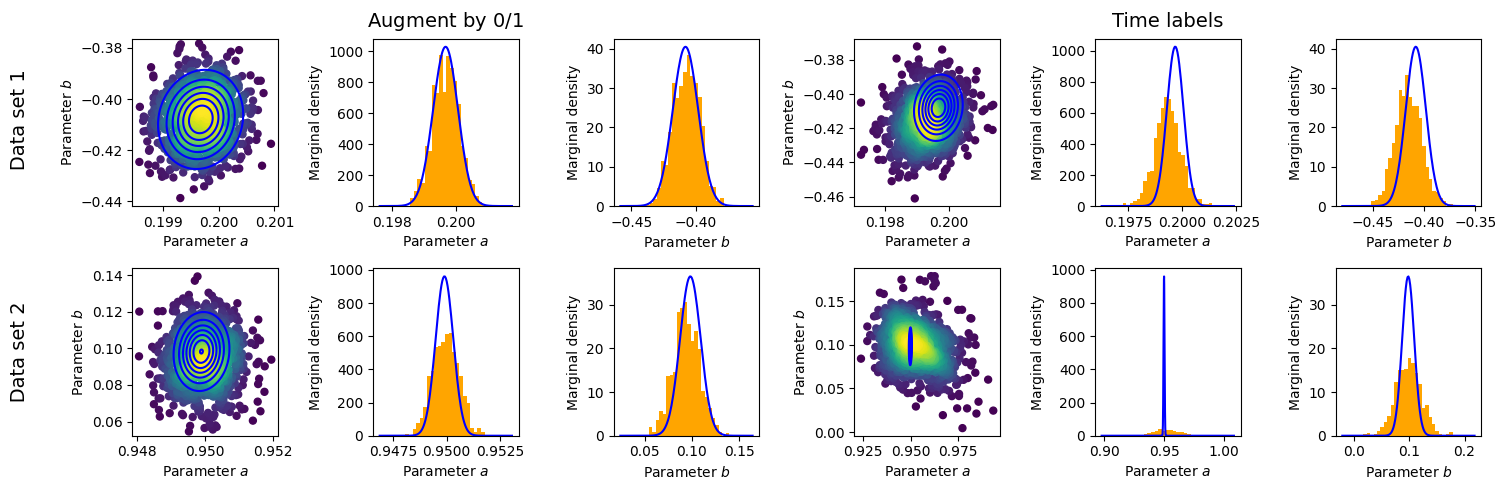

In [5]:
# Skip this cell

fig, ax = plt.subplots(2, 6, figsize=((15, 5)))
n_post_samples = 1000

for i_result, (param_prior, result) in enumerate(zip(param_priors, results)):
    for i_amortizer, (amortizer, label) in enumerate([
        (amortizer_augment01, "Augment by $0/1$"),
        (amortizer_timelabels, "Time labels"),
    ]):
        if i_amortizer == 0:
            x_data = np.ones((1, n_obs, 2), dtype=np.float32)
            x_data[0, :, 0] = result[0]
            missing_indices = np.setdiff1d(range(n_obs), result[1])
            x_data[0][missing_indices] = np.array([-5.0, 0.0])
        else:
            n_present = len(result[1])
            x_data = np.ones((1, n_present, 2), dtype=np.float32)
            x_data[0, :, 0] = result[0][result[1]]
            x_data[0, :, 1] = result[2]
        param_samples = amortizer.sample(x_data, n_post_samples)
        plot_posterior(ax, i_result, i_amortizer, result, param_samples, label)

fig.supylabel('   Data set 2                     Data set 1', fontsize=14, x=-0.0005)                      
plt.tight_layout()
plt.show()
fig.savefig("figures/Osc_augment_time.png", dpi=300, bbox_inches='tight') 
fig.savefig("figures/Osc_augment_time.pdf", bbox_inches='tight') 

In [5]:
# Encode missing data
x_datas = []
for result in results:
    x_datas.append({})

    x_data = np.ones((1, n_obs, 2), dtype=np.float32)
    x_data[0, :, 0] = result[0]
    missing_indices = np.setdiff1d(range(n_obs), result[1])
    x_data[0][missing_indices] = np.array([-5.0, 0.0])
    x_datas[-1]["augment01"] = x_data
    
    n_present = len(result[1])
    x_data = np.ones((1, n_present, 2), dtype=np.float32)
    x_data[0, :, 0] = result[0][result[1]]
    x_data[0, :, 1] = result[2]
    x_datas[-1]["timelabels"] = x_data

# Sample from BayesFlow
samples = []
for result_ix, result in enumerate(results):
    samples.append({})
    for amortizer_id, amortizer in amortizers.items():
        x_data = x_datas[result_ix][amortizer_id]
        samples[-1][amortizer_id] = amortizer.sample(x_data, n_post_samples)

# Calculate integration boundaries
bounds = []
for dct in samples:
    bounds.append({})
    for amortizer_id, param_samples in dct.items():
        mean_sample = np.mean(param_samples, axis=0)
        cov_sample = np.cov(param_samples.transpose())
        mean_x = mean_sample[0]
        mean_y = mean_sample[1]
        
        std_x = np.sqrt(cov_sample[0, 0])
        std_y = np.sqrt(cov_sample[1, 1])
        lb_x = mean_x - 3*std_x
        ub_x = mean_x + 3*std_x
        lb_y = mean_y - 3*std_y
        ub_y = mean_y + 3*std_y
        bounds[-1][amortizer_id] = ((lb_x, ub_x), (lb_y, ub_y))

## Posterior plots

In [6]:
# Calculate analytical posteriors

def get_posterior(result, bounds):
    ((lb_x, ub_x), (lb_y, ub_y)) = bounds

    def prior_eval(a,b):
        # Evaluates prior probability p(theta) according to a ~ U(0.1, 1) & shift parameter b ~ N(0, 0.25²)
        if a > 0.1 and a < 1.0:
            return 1/0.9 * norm.pdf(b, 0.0, 0.25)
        else: 
            return 0.

    def likelihood(a,b):   
        # Calculates likelihood of available data
        residual = (result[0][result[1]] - (np.sin(a*2*np.pi*result[2]) + b))/sigma
        nllh = np.sum(np.log(2*np.pi*sigma**2)+residual**2)/2
        return np.exp(-nllh)

    def unnormalized_posterior(a,b):   
        # Evaluates the unnormalized posterior probability according to Bayes' formula
        return likelihood(a,b) * prior_eval(a,b)

    # scaling factor
    scaling_factor = dblquad(unnormalized_posterior, lb_y, ub_y, lambda y: lb_x, lambda y: ub_x)

    posterior = lambda x,y: unnormalized_posterior(x,y) / scaling_factor[0]
    return posterior

posteriors = []
for result_ix, result in enumerate(results):
    posteriors.append({})
    for amortizer_id, param_samples in samples[result_ix].items():
        _bounds = bounds[result_ix][amortizer_id]
        posteriors[-1][amortizer_id] = get_posterior(result, _bounds)

In [7]:
cmap = "viridis"
amortizer_labels = {"augment01": "Augment $0/1$", "timelabels": "Time labels"}

def plot_posterior2(ax, result, posterior, param_samples, amortizer_id, result_ix, levels=None):
    mean_sample = np.mean(param_samples, axis=0)
    cov_sample = np.cov(param_samples.transpose())
    mean_x = mean_sample[0]
    mean_y = mean_sample[1]
    mins, maxs = param_samples.min(axis=0), param_samples.max(axis=0)
    xmin, ymin = mins
    xmax, ymax = maxs
    # Level sets of analytic posterior distribution
    grid = 201
    A = np.linspace(xmin, xmax, grid)
    #if i==1 and j==1:
    #    A = np.linspace(0.948, 0.952, grid)
    B = np.linspace(ymin, ymax, grid)
    true_posterior = np.zeros((grid, grid))
    for iy in range(0, grid):
        for ix in range(0, grid):
            true_posterior[iy][ix] = posterior(A[ix], B[iy])   
    _cs = ax.contour(A, B, true_posterior, cmap=cmap)
    
    # Kernel density estimator of BayesFlow samples
    a = param_samples[:, 0]
    b = param_samples[:, 1]
    ab = np.vstack([a, b])
    z = stats.gaussian_kde(ab)(ab)
    ida = z.argsort()  # Sort the points by density, so that the densest points are plotted last
    a, b, z = a[ida], b[ida], z[ida]
    approximate_posterior = ax.scatter(a, b, c=z, s=10, cmap=cmap, alpha=0.1)

    ax.set_xlabel('Parameter $a$')
    ax.set_ylabel('Parameter $b$')
    ax.set_title(amortizer_labels[amortizer_id])
    
    #if result_ix == 0:
    #    ax.set_xlim([0.198, 0.201])
    #    ax.set_ylim([-0.45, -0.37])
    #elif result_ix == 1:
    #    ax.set_xlim([0.948, 0.9525])
    #    ax.set_ylim([0.05, 0.15])

CPU times: user 13 s, sys: 366 ms, total: 13.3 s
Wall time: 12.8 s


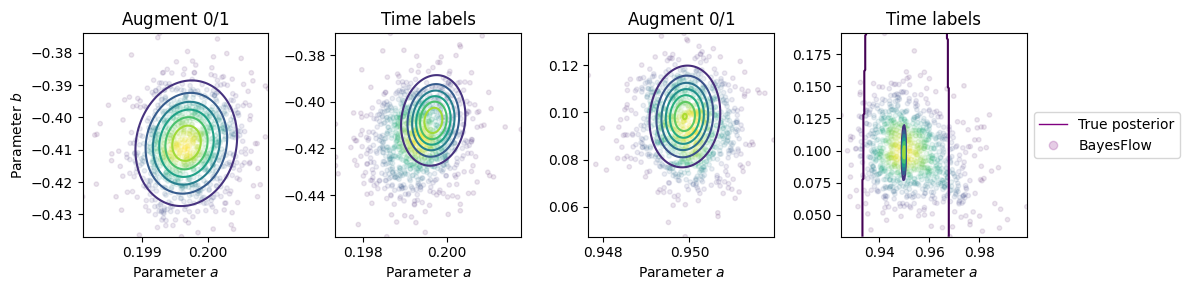

In [9]:
%%time 

fig, axes = plt.subplots(1, 4, figsize=(12, 3))

for result_ix, result in enumerate(results):
    for amortizer_ix, (amortizer_id, amortizer) in enumerate(amortizers.items()):
        posterior = posteriors[result_ix][amortizer_id]
        param_samples = samples[result_ix][amortizer_id]
        
        ax = axes[result_ix * 2 + amortizer_ix]
        plot_posterior2(ax, result, posterior, param_samples, amortizer_id, result_ix)
        if result_ix > 0 or amortizer_ix > 0:
            ax.set_ylabel(None)

# Legend
legend_elements = [
    Line2D([0], [0], color="purple", lw=1, label="True posterior"),
    Line2D([0], [0], color="purple", markerfacecolor="purple", marker="o", lw=0, markersize=6, alpha=0.2, label="BayesFlow"),
]
axes[-1].legend(handles=legend_elements, loc="center left", bbox_to_anchor=(1, 0.5))
fig.tight_layout()

## Posterior predictive checks

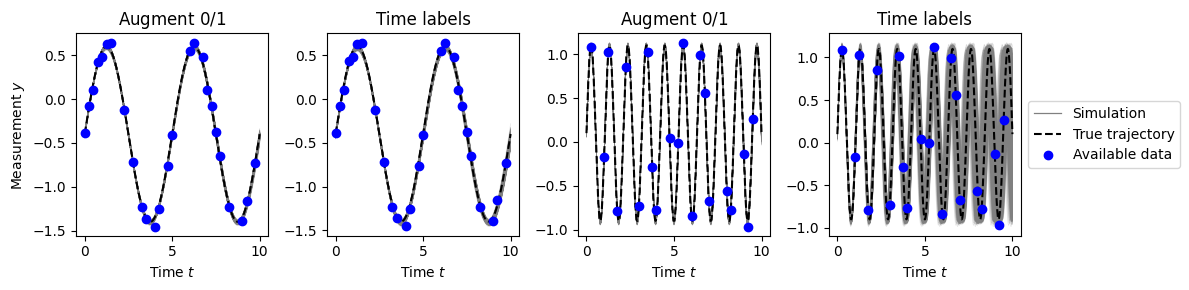

In [8]:
# Posterior predictive check
fig, axes = plt.subplots(1, 4, figsize=(12, 3))

time_line = np.linspace(0, 10, 501)

def plot_predictive_check(ax, param_prior, x_data, result, param_samples):

    for k in range(1000):
        a = param_samples[k, 0]   # frequency
        b = param_samples[k, 1]   # shift    
        if k == 0:
            ax.plot(np.array([0]), np.array([0]), color='grey', label='Simulation', linewidth=0.9)
        else: 
            ax.plot(time_line, np.sin(a*2*np.pi*time_line) + b, color='grey', linewidth=0.5, alpha=0.2)
    
    a = param_prior[0, 0]   # frequency
    b = param_prior[0, 1]   # shift
    ax.plot(time_line, np.sin(a*2*np.pi*time_line) + b, color='black', linestyle="dashed", label='True trajectory')    
    
    present_indices = result[1]
    missing_indices = np.setdiff1d(range(n_obs), present_indices)
    ax.plot(time_points[present_indices], result[0][present_indices], 'o', color='blue', label='Available data')
    ax.set_title(amortizer_labels[amortizer_id])
    ax.set_xlabel('Time $t$')
    ax.set_ylabel("Measurement $y$")
    
    
for result_ix, (param_prior, result) in enumerate(zip(param_priors, results)):
    for amortizer_ix, (amortizer_id, amortizer) in enumerate(amortizers.items()):
        param_samples = samples[result_ix][amortizer_id]
        ax = axes[result_ix * 2 + amortizer_ix]
        plot_predictive_check(ax, param_prior, x_data, result, param_samples)
        if result_ix > 0 or amortizer_ix > 0:
            ax.set_ylabel(None)

axes[-1].legend(loc="center left", bbox_to_anchor=(1,0.5))
fig.tight_layout()

## Combine everything

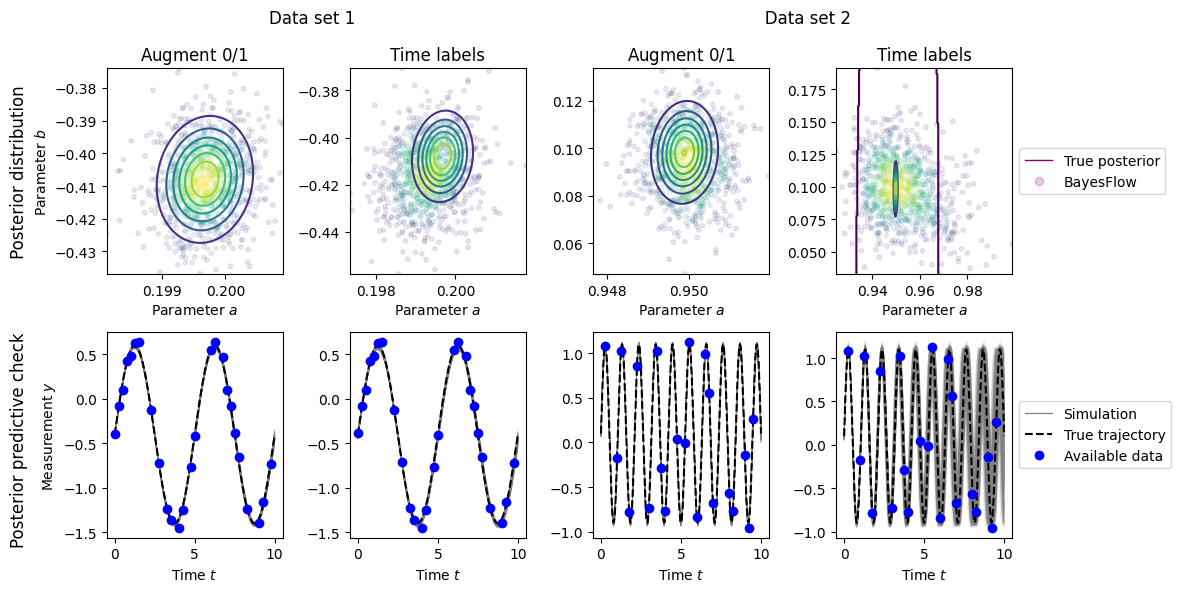

In [11]:
fig, axes_all = plt.subplots(2, 4, figsize=(12, 6))

axes = axes_all[0, :]
for result_ix, result in enumerate(results):
    for amortizer_ix, (amortizer_id, amortizer) in enumerate(amortizers.items()):
        posterior = posteriors[result_ix][amortizer_id]
        param_samples = samples[result_ix][amortizer_id]
        
        ax = axes[result_ix * 2 + amortizer_ix]
        plot_posterior2(ax, result, posterior, param_samples, amortizer_id, result_ix)
        if result_ix > 0 or amortizer_ix > 0:
            ax.set_ylabel(None)
            
# Legend
legend_elements = [
    Line2D([0], [0], color="purple", lw=1, label="True posterior"),
    Line2D([0], [0], color="purple", markerfacecolor="purple", marker="o", lw=0, markersize=6, alpha=0.2, label="BayesFlow"),
]
axes[-1].legend(handles=legend_elements, loc="center left", bbox_to_anchor=(1, 0.5))

axes = axes_all[1, :]
for result_ix, (param_prior, result) in enumerate(zip(param_priors, results)):
    for amortizer_ix, (amortizer_id, amortizer) in enumerate(amortizers.items()):
        param_samples = samples[result_ix][amortizer_id]
        ax = axes[result_ix * 2 + amortizer_ix]
        plot_predictive_check(ax, param_prior, x_data, result, param_samples)
        if result_ix > 0 or amortizer_ix > 0:
            ax.set_ylabel(None)
        ax.set_title(None)

axes[-1].legend(loc="center left", bbox_to_anchor=(1,0.5))
fig.suptitle("Data set 1                                                                              Data set 2          ")
fig.supylabel("Posterior predictive check              Posterior distribution       ")

fig.tight_layout()
for fmt in ["png", "pdf"]:
    fig.savefig(f"figures/Osc_augment_time.{fmt}", dpi=300, bbox_inches='tight')